In [ ]:
import pandas as pd
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt

from itertools import chain
from tqdm.auto import tqdm
from ast import literal_eval
from collections import defaultdict, Counter
from datasets import Dataset, concatenate_datasets, load_dataset
tqdm.pandas()

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Functions
def load_df(path):
    df = pd.read_csv(path, delimiter='\t').rename(columns={
        'EC number':'EC',
        'Gene Ontology (molecular function)':'MF',
        'Gene Ontology (biological process)':'BP',
        'Gene Ontology (cellular component)':'CC',
        'InterPro':'IP',
        'Gene3D':'3D',
        'Sequence':'seqs'
    }).astype('string')
    print(len(df))
    df['combined'] = df.progress_apply(lambda x: ' '.join(str(x[col]) for col in df.columns if col != 'seqs'), axis=1)
    df = df.sort_values(by='combined', key=lambda x: x.str.len(), ascending=False)
    df = df.drop_duplicates(subset='seqs', keep='first')
    df = df.drop('combined', axis=1)
    df = df.reset_index(drop=True)
    print(len(df))
    return df


def create_dictionary(input, start=1, name='ec'):
    id2label, label2id = {}, {}
    for index, entry in enumerate(input, start=start):
        entry = entry + '_' + name
        id2label[index] = entry
        label2id[entry] = index
    return id2label, label2id


def process_descriptors(input_list,
                        start=1,
                        name='ec',
                        id2label=None,
                        label2id=None,
                        filter_func=lambda d: d.strip()):
    col_list, new_col = [], []

    if id2label == None or label2id == None:
        for item in tqdm(input_list, desc=f'{name} make dicts'):
            descriptors = str(item).split(';')
            filtered_descriptors = [filter_func(d) for d in descriptors]
            filtered_descriptors = [d for d in filtered_descriptors if d and d.lower() != 'none' and d.lower() != 'nan']
            col_list.extend(filtered_descriptors)
        col_list = sorted(list(set(col_list)))
        if '' in col_list:
            col_list.remove('')
        len_col_list = len(col_list)
        id2label, label2id = create_dictionary(col_list, start=start, name=name)
    else:
        len_col_list = len(id2label.keys())

    for item in tqdm(input_list, desc=f'{name} make new column'):
        descriptors = str(item).split(';')
        filtered_descriptors = [filter_func(d) for d in descriptors]
        filtered_descriptors = [d for d in filtered_descriptors if d and d.lower() != 'none' and d.lower() != 'nan']
        new_entry = [label2id[d + '_' + name] for d in filtered_descriptors if d] or [0]
        new_col.append(new_entry)

    return new_col, id2label, label2id, len_col_list + start


def ec_processing(input_list, start=1, name='ec', id2label=None, label2id=None):
    return process_descriptors(input_list, start=start, name=name, id2label=id2label, label2id=label2id,
                               filter_func=lambda d: d.strip() if '-' not in d and 'n' not in d else '')


def go_processing(input_list, start=1, name='go', id2label=None, label2id=None):
    return process_descriptors(input_list, start=start, name=name, id2label=id2label, label2id=label2id,
                               filter_func=lambda d: d[d.find('[GO:')+1:d.find(']')].strip())


def cofactor_processing(input_list, start=1, name='co', id2label=None, label2id=None):
    return process_descriptors(input_list, start=start, name=name, id2label=id2label, label2id=label2id,
                               filter_func=lambda d: d[d.find('Name=')+5:].strip() if 'Name' in d else '')


def domain_processing(input_list, start=1, name='ip', id2label=None, label2id=None):
    return process_descriptors(input_list, start=start, name=name, id2label=id2label, label2id=label2id)


def replace_df(df, all_cols):
    new_ec_col, new_mf_col, new_bp_col, new_cc_col, new_ip_col, new_threed_col, new_co_col = all_cols
    combined_list = [sorted([item for item in list(chain.from_iterable(element)) if item != 0])
                     for element in zip(*all_cols) if element != [0]]

    df['EC'] = new_ec_col
    df['Cofactor'] = new_co_col
    df['MF'] = new_mf_col
    df['BP'] = new_bp_col
    df['CC'] = new_cc_col
    df['IP'] = new_ip_col
    df['3D'] = new_threed_col
    df['combined'] = combined_list
    df['string_combined'] = df['combined'].astype('string')

    unique_dict = {}

    # Iterate over the DataFrame and update the dictionary
    for _, row in tqdm(df.iterrows(), total=len(df)):
        combined_value = row['string_combined']
        if combined_value not in unique_dict:
            unique_dict[combined_value] = row
        if combined_value == '[0]':
            print(combined_value)

    # Create the final DataFrame from the dictionary values
    df_final = pd.DataFrame(unique_dict.values()).drop(columns=['string_combined'])
    return df_final

In [ ]:
# Train data
df = load_df('swiss_prot_raw.tsv')
# EC
ecs = df['EC'].tolist()
new_ec_col, id2ec, ec2id, ec_len = ec_processing(ecs, name='ec', start=1)
# MF
mfs = df['MF'].tolist()
new_mf_col, id2mf, mf2id, mf_len = go_processing(mfs, name='mf', start=ec_len+1)
# BP
bps = df['BP'].tolist()
new_bp_col, id2bp, bp2id, bp_len = go_processing(bps, name='bp', start=mf_len+1)
# CC
ccs = df['CC'].tolist()
new_cc_col, id2cc, cc2id, cc_len = go_processing(ccs, name='cc', start=bp_len+1)
# IP
ips = df['IP'].tolist()
new_ip_col, id2ip, ip2id, ip_len = domain_processing(ips, name='ip', start=cc_len+1)
# 3D
threeds = df['3D'].tolist()
new_threed_col, id2threed, threed2id, threed_len = domain_processing(threeds, name='3d', start=ip_len+1)
# cofactor
cos = df['Cofactor'].tolist()
new_co_col, id2co, co2id, co_len = cofactor_processing(cos, name='co', start=threed_len+1)

# make full dicts and check for no duplicates
all_id = [id2ec, id2mf, id2bp, id2cc, id2ip, id2threed, id2co]
all_label = [ec2id, mf2id, bp2id, cc2id, ip2id, threed2id, co2id]

id2label, label2id = {}, {}

key_counts = 0
for d in all_id:
    key_counts += len(d.keys())
    id2label.update(d)
print(key_counts)

key_counts = 0
for d in all_label:
    key_counts += len(d.keys())
    label2id.update(d)
print(key_counts)

for k, v in id2label.items():
    if k != label2id[v]:
        print(v)

for k, v in label2id.items():
    if k != id2label[v]:
        print(v)

print(len(id2label.keys()), len(label2id.keys()))

all_cols = [new_ec_col, new_mf_col, new_bp_col, new_cc_col, new_ip_col, new_threed_col, new_co_col]

df_final = replace_df(df, all_cols)

print(len(df_final))

df_final.to_csv('processed_swiss_prot.csv', index=False)

In [ ]:
# Test data
df = load_df('trembl_all_aspects_raw.tsv')
# EC
ecs = df['EC'].tolist()
new_ec_col, id2ec, ec2id, ec_len = ec_processing(ecs, name='ec', start=1)
# MF
mfs = df['MF'].tolist()
new_mf_col, id2mf, mf2id, mf_len = go_processing(mfs, name='mf', start=ec_len+1)
# BP
bps = df['BP'].tolist()
new_bp_col, id2bp, bp2id, bp_len = go_processing(bps, name='bp', start=mf_len+1)
# CC
ccs = df['CC'].tolist()
new_cc_col, id2cc, cc2id, cc_len = go_processing(ccs, name='cc', start=bp_len+1)
# IP
ips = df['IP'].tolist()
new_ip_col, id2ip, ip2id, ip_len = domain_processing(ips, name='ip', start=cc_len+1)
# 3D
threeds = df['3D'].tolist()
new_threed_col, id2threed, threed2id, threed_len = domain_processing(threeds, name='3d', start=ip_len+1)
# cofactor
cos = df['Cofactor'].tolist()
new_co_col, id2co, co2id, co_len = cofactor_processing(cos, name='co', start=threed_len+1)


all_cols = [new_ec_col, new_mf_col, new_bp_col, new_cc_col, new_ip_col, new_threed_col, new_co_col]
df = replace_df(df, all_cols)

# remove dups
for col in df.columns:
    mask = df[col].apply(lambda x: x != [0]
                        and (not isinstance(x, list) or len(x) > 0)
                        and (not isinstance(x, str) or x.strip() != '[]'))
    df = df.loc[mask]

df_filtered = df[~df['seqs'].isin(df_final['seqs'])]

print(len(df_filtered))
df_filtered.to_csv('processed_trembl.csv', index=False)

In [34]:
# Loading previously processed
#df = pd.read_csv('processed_trembl.csv', converters={
df = pd.read_csv('processed_swiss_prot.csv', converters={
    'EC': literal_eval,
    'Cofactor': literal_eval,
    'MF': literal_eval,
    'BP': literal_eval,
    'CC': literal_eval,
    'IP': literal_eval,
    '3D': literal_eval,
    'combined': literal_eval
})

df = df.drop('Cofactor', axis=1)

df['combined'] = df['combined'].apply(set)


ec_aspect = df['EC'].apply(set).tolist()
mf_aspect = df['MF'].apply(set).tolist()
bp_aspect = df['BP'].apply(set).tolist()
cc_aspect = df['CC'].apply(set).tolist()
ip_aspect = df['IP'].apply(set).tolist()
threed_aspect = df['3D'].apply(set).tolist()

single_aspect_dict = {
    'EC': ec_aspect,
    'MF': mf_aspect,
    'BP': bp_aspect,
    'CC': cc_aspect,
    'IP': ip_aspect,
    '3D': threed_aspect
}

print(df.head(1))


sets = df['combined'].tolist()

n = len(sets)
all_indices = set(range(n))
aspect_dict = defaultdict(set)

for i, s in tqdm(enumerate(sets), total=n):
    for item in s:
        aspect_dict[item].add(i)

    Entry   Entry Name                                               seqs  \
0  Q02248  CTNB1_MOUSE  MATQADLMELDMAMEPDRKAAVSHWQQQSYLDSGIHSGATTTAPSL...   

       EC                                                 BP  \
0  [5477]  [26767, 19888, 19887, 23051, 16509, 26947, 207...   

                                                  CC  \
0  [31711, 32847, 33005, 31957, 31958, 31956, 321...   

                                                  MF  \
0  [10201, 10203, 5759, 11935, 12361, 13088, 8636...   

                             IP       3D  \
0  [43515, 46062, 34324, 44351]  [68872]   

                                            combined  
0  {5635, 5636, 11780, 30728, 18953, 23051, 26123...  


  0%|          | 0/137676 [00:00<?, ?it/s]

In [35]:
def find_random_disjoint_set_index(all_aspects, all_entries):
    indices = list(range(len(all_entries)))
    random.shuffle(indices)

    for idx in indices:
        if all_aspects.isdisjoint(all_entries[idx]):
            return idx
    
    return None


triplets = {
    'EC': [],
    'MF': [],
    'BP': [],
    'CC': [],
    'IP': [],
    '3D': []
}

num_epochs = 1
batch_rows = 1000

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    for i, row in tqdm(df.iterrows(), total=len(df)):
        p, p_categories = row[['seqs', 'combined']]

        if i % batch_rows == 0:
            total_triplets = sum(len(triplets[aspect]) for aspect in triplets)
            tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Total triplets: {total_triplets}")

        for aspect in triplets.keys():
            chosen_aspect = random.choice(row[aspect])
            if chosen_aspect != 0:
                valid_anchor_idxs = aspect_dict[chosen_aspect] - {i}
                if len(valid_anchor_idxs) > 0:
                    a_idx = random.choice(tuple(valid_anchor_idxs))
                    a, a_categories = df.loc[a_idx, ['seqs', 'combined']] # all aspects is already a set

                    all_categories = p_categories.union(a_categories)

                    n_idx = find_random_disjoint_set_index(all_categories, sets) ### MODIFY
                    ### TODO
                    # only enforce negative doesn't match in the chosen aspect
                    # remove cofactor, do on the side
                    if n_idx != None:
                        n = df.loc[n_idx, 'seqs']
                        
                        triplets[aspect].append((p, a, n))
                    else:
                        continue
                else:
                    continue
            else:
                continue


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/137676 [00:00<?, ?it/s]

Epoch 1/1 - Total triplets: 0
Epoch 1/1 - Total triplets: 5977
Epoch 1/1 - Total triplets: 11940
Epoch 1/1 - Total triplets: 17902
Epoch 1/1 - Total triplets: 23864
Epoch 1/1 - Total triplets: 29815
Epoch 1/1 - Total triplets: 35780
Epoch 1/1 - Total triplets: 41731
Epoch 1/1 - Total triplets: 47669
Epoch 1/1 - Total triplets: 53608
Epoch 1/1 - Total triplets: 59565
Epoch 1/1 - Total triplets: 65495
Epoch 1/1 - Total triplets: 71431
Epoch 1/1 - Total triplets: 77369
Epoch 1/1 - Total triplets: 83304
Epoch 1/1 - Total triplets: 89233
Epoch 1/1 - Total triplets: 95145
Epoch 1/1 - Total triplets: 101070
Epoch 1/1 - Total triplets: 106986
Epoch 1/1 - Total triplets: 112903
Epoch 1/1 - Total triplets: 118811
Epoch 1/1 - Total triplets: 124701
Epoch 1/1 - Total triplets: 130620
Epoch 1/1 - Total triplets: 136515
Epoch 1/1 - Total triplets: 142420
Epoch 1/1 - Total triplets: 148323
Epoch 1/1 - Total triplets: 154224
Epoch 1/1 - Total triplets: 160126
Epoch 1/1 - Total triplets: 166025
Epoch 1

EC 124740
MF 136994
BP 137266
CC 137626
IP 133696
3D 137090
Top 5 most repeated entries in ps:
Count: MATQADLMELDMAMEPDRKAAVSHWQQQSYLDSGIHSGATTTAPSLSGKGNPEEEDVDTSQVLYEWEQGFSQSFTQEQVADIDGQYAMTRAQRVRAAMFPETLDEGMQIPSTQFDAAHPTNVQRLAEPSQMLKHAVVNLINYQDDAELATRAIPELTKLLNDEDQVVVNKAAVMVHQLSKKEASRHAIMRSPQMVSAIVRTMQNTNDVETARCTAGTLHNLSHHREGLLAIFKSGGIPALVKMLGSPVDSVLFYAITTLHNLLLHQEGAKMAVRLAGGLQKMVALLNKTNVKFLAITTDCLQILAYGNQESKLIILASGGPQALVNIMRTYTYEKLLWTTSRVLKVLSVCSSNKPAIVEAGGMQALGLHLTDPSQRLVQNCLWTLRNLSDAATKQEGMEGLLGTLVQLLGSDDINVVTCAAGILSNLTCNNYKNKMMVCQVGGIEALVRTVLRAGDREDITEPAICALRHLTSRHQEAEMAQNAVRLHYGLPVVVKLLHPPSHWPLIKATVGLIRNLALCPANHAPLREQGAIPRLVQLLVRAHQDTQRRTSMGGTQQQFVEGVRMEEIVEGCTGALHILARDVHNRIVIRGLNTIPLFVQLLYSPIENIQRVAAGVLCELAQDKEAAEAIEAEGATAPLTELLHSRNEGVATYAAAVLFRMSEDKPQDYKKRLSVELTSSLFRTEPMAWNETADLGLDIGAQGEALGYRQDDPSYRSFHSGGYGQDALGMDPMMEHEMGGHHPGADYPVDGLPDLGHAQDLMDGLPPGDSNQLAWFDTDL
Entry: 6

Count: MATQADLMELDMAMEPDRKAAVSHWQQQSYLDSGIHSGATTTAPSLSGKGNPEEEDVDTSQVLYEWEQGFSQSFTQEQVADIDGQYAMTRAQRVRAAMF

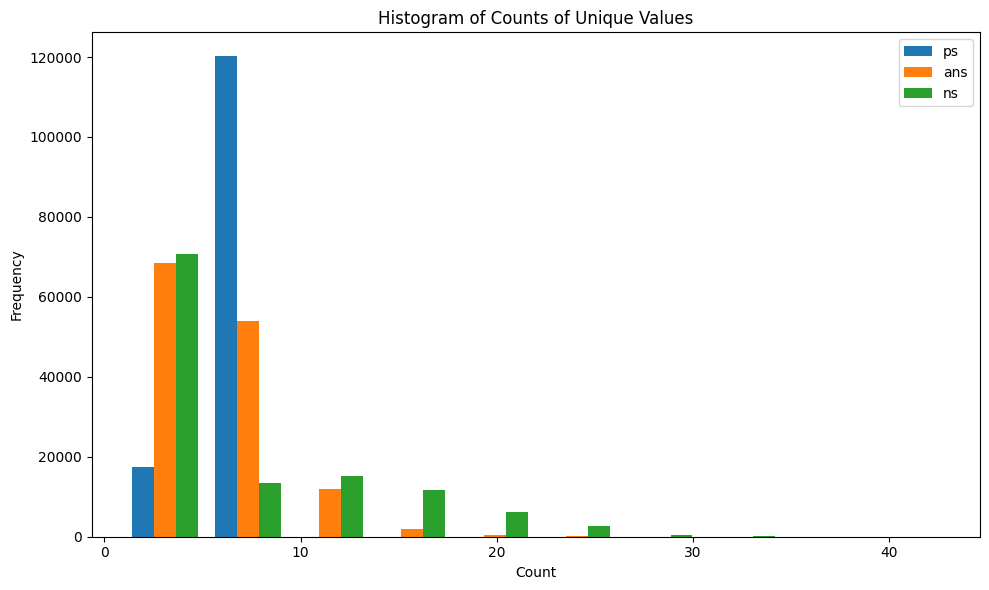

Dataset({
    features: ['positives', 'anchors', 'negatives', 'aspects'],
    num_rows: 807412
})


In [36]:
for i, (k, v) in enumerate(triplets.items()):
    print(k, len(v))

ps, ans, ns, acs = [], [], [], []
for i, (k, v) in enumerate(triplets.items()):
    for trip in v:
        p, a, n = trip
        ps.append(p)
        ans.append(a)
        ns.append(n)
        acs.append(i)

ps_counts = Counter(ps)
ans_counts = Counter(ans)
ns_counts = Counter(ns)

print("Top 5 most repeated entries in ps:")
for count, entry in ps_counts.most_common(5):
    print(f"Count: {count}")
    print(f"Entry: {entry}")
    print()

print("Top 5 most repeated entries in ans:")
for count, entry in ans_counts.most_common(5):
    print(f"Count: {count}")
    print(f"Entry: {entry}")
    print()

print("Top 5 most repeated entries in ns:")
for count, entry in ns_counts.most_common(5):
    print(f"Count: {count}")
    print(f"Entry: {entry}")
    print()

# Prepare the data for plotting
data = [list(ps_counts.values()), list(ans_counts.values()), list(ns_counts.values())]
labels = ['ps', 'ans', 'ns']

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram
ax.hist(data, bins=10, label=labels)

# Set labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Counts of Unique Values')

# Add a legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

data = Dataset.from_dict({
    'positives':ps,
    'anchors':ans,
    'negatives':ns,
    'aspects':acs
})

print(data)

In [ ]:
validation_set = data.train_test_split(test_size=5000, seed=42)
valid_set = validation_set["test"]
test_set = validation_set["train"]

# Print the sizes of the resulting sets
print(f"Validation set size: {valid_set.num_rows}")
print(f"Test set size: {test_set.num_rows}")

valid_set.push_to_hub('lhallee/triplets', split='valid')
test_set.push_to_hub('lhallee/triplets', split='test')

In [37]:
data.push_to_hub('lhallee/triplets', split='train')

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/270 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/270 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/270 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/520 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/lhallee/triplets/commit/edb34ac26062961130fafe0e532579a24c6f5ed7', commit_message='Upload dataset', commit_description='', oid='edb34ac26062961130fafe0e532579a24c6f5ed7', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
### test disjointness

def find_random_disjoint_set_index_test(all_aspects, all_entries):
    random.shuffle(all_entries)
    idxs = []
    for index, entry_set in enumerate(all_entries):
        if all_aspects.isdisjoint(entry_set):
            idxs.append(all_entries.index(entry_set))
    
    return idxs

counts = []
combineds = df['combined'].tolist()[:10]

for i, combined in tqdm(enumerate(combineds), total=10):
    counts.append(len(find_random_disjoint_set_index_test(combined, sets)))
    print(counts)

In [ ]:
counts

In [ ]:
import pickle
with open('triplets_epoch_1.pkl', 'wb') as f:
    pickle.dump(triplets, f)

In [ ]:
# For looking / documenting swiss prot duplicates
seqs = df['seqs'].tolist()
entry_ids = df['Entry'].tolist()
print(len(seqs), len(list(set(seqs))))

counts = {}
duplicates = {}

for i, seq in enumerate(seqs):
    if seq in counts:
        counts[seq] += 1
        duplicates[seq].append(entry_ids[i])
    else:
        counts[seq] = 1
        duplicates[seq] = [entry_ids[i]]

# Write duplicates to a text file
with open("swiss_prot_duplicates.txt", "w") as file:
    for seq, ids in duplicates.items():
        if len(ids) > 1:
            count = len(ids)
            file.write(f"{count}\t{' '.join(ids)}\n")
            file.write(f"{seq}\n")

In [ ]:
### proof of concept for steering away from used a and n
"""
def find_weighted_random_disjoint_set_index(all_aspects, all_entries, probabilities, max_iterations=100):
    for _ in range(max_iterations):
        index = random.choices(range(len(all_entries)), probabilities)[0]
        if all_aspects.isdisjoint(all_entries[index]):
            return index

    return None


triplets = {
    'EC': [],
    'Cofactor': [],
    'MF': [],
    'BP': [],
    'CC': [],
    'IP': [],
    '3D': []
}

num_epochs = 1
len_df = len(df)

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    freq_counter = Counter()
    batch_rows = 1000
    probabilities = None

    for i, row in tqdm(df.iterrows(), total=len_df, desc='Going through DF'):
        if i % batch_rows == 0:
            weights = [1 / (freq_counter[idx] + 1) for idx in range(len_df)]
            total_weight = sum(weights)
            probabilities = [weight / total_weight for weight in weights]

            total_triplets = sum(len(triplets[aspect]) for aspect in triplets)
            tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Total triplets: {total_triplets}")

        p, p_all_aspects = row[['seqs', 'combined']]

        for aspect in triplets.keys():
            chosen_aspect = random.choice(row[aspect])
            if chosen_aspect != 0:
                valid_anchor_idxs = list(aspect_dict[chosen_aspect] - {i})
                if valid_anchor_idxs:
                    anchor_set = set(valid_anchor_idxs)
                    temp_prob = [value for index, value in enumerate(valid_anchor_idxs) if index in anchor_set]
                    a_idx = random.choices(valid_anchor_idxs, temp_prob)[0]

                    a, a_all_aspects = df.loc[a_idx, ['seqs', 'combined']]

                    all_aspects = p_all_aspects.union(a_all_aspects)

                    n_idx = find_weighted_random_disjoint_set_index(all_aspects, sets, probabilities)
                    if n_idx:
                        freq_counter[a_idx] += 1
                        freq_counter[n_idx] += 1
                        n = df.loc[n_idx, 'seqs']
                        
                        triplets[aspect].append((p, a, n))
"""